<a href="https://colab.research.google.com/github/ianomunga/quantiumAnalytics/blob/main/quantiumChipAnalytics_Task_1_Ian_Omung'a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##*Dependencies*
Importing the code dependencies this analysis will rely on

In [2]:
# For data frames and statistical analyses
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# For visualizations based on the statisical anlyses
import missingno
import matplotlib.pyplot as plt
import seaborn as sns


# For datetime management
import datetime
from matplotlib.dates import DateFormatter

# For textual analyses of the bits natural language within the dataset
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
import re

# For cleaning out the warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##*Data* 
Loading the datasets being analyzed into Pandas Data Frames

In [3]:
consumerData_df = pd.read_csv("/content/data/QVI_purchase_behaviour.csv")
transactionData_df = pd.read_excel("/content/data/QVI_transaction_data.xlsx")

# Analyzing The Transactional Data

In [4]:
transactionData_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
len(transactionData_df)

264836

In [6]:
#Looking for duplicate values
transactionData_df[transactionData_df.duplicated(['TXN_ID'])].head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
42,43605,55,55073,48887,113,Twisties Chicken270g,1,4.6
377,43475,7,7364,7739,20,Doritos Cheese Supreme 330g,2,11.4
419,43391,12,12301,10982,93,Doritos Corn Chip Southern Chicken 150g,2,7.8
476,43351,16,16427,14546,81,Pringles Original Crisps 134g,1,3.7
511,43315,19,19272,16683,31,Infzns Crn Crnchers Tangy Gcamole 110g,2,7.6


Transactional data possible contains copies since mutiple rows representing multiple purchases could have been made as part of a single transaction.
This conjecture can be confirmed as shown below by checking for duplicate value sets from one of the 5 fields given above

In [8]:
# Confirming duplication conjecture

transactionData_df.loc[transactionData_df['TXN_ID'] == 7739,:]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
376,43475,7,7364,7739,50,Tostitos Lightly Salted 175g,2,8.8
377,43475,7,7364,7739,20,Doritos Cheese Supreme 330g,2,11.4


In [9]:
#For obtaining the types of data from the dataset in entirety
transactionData_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


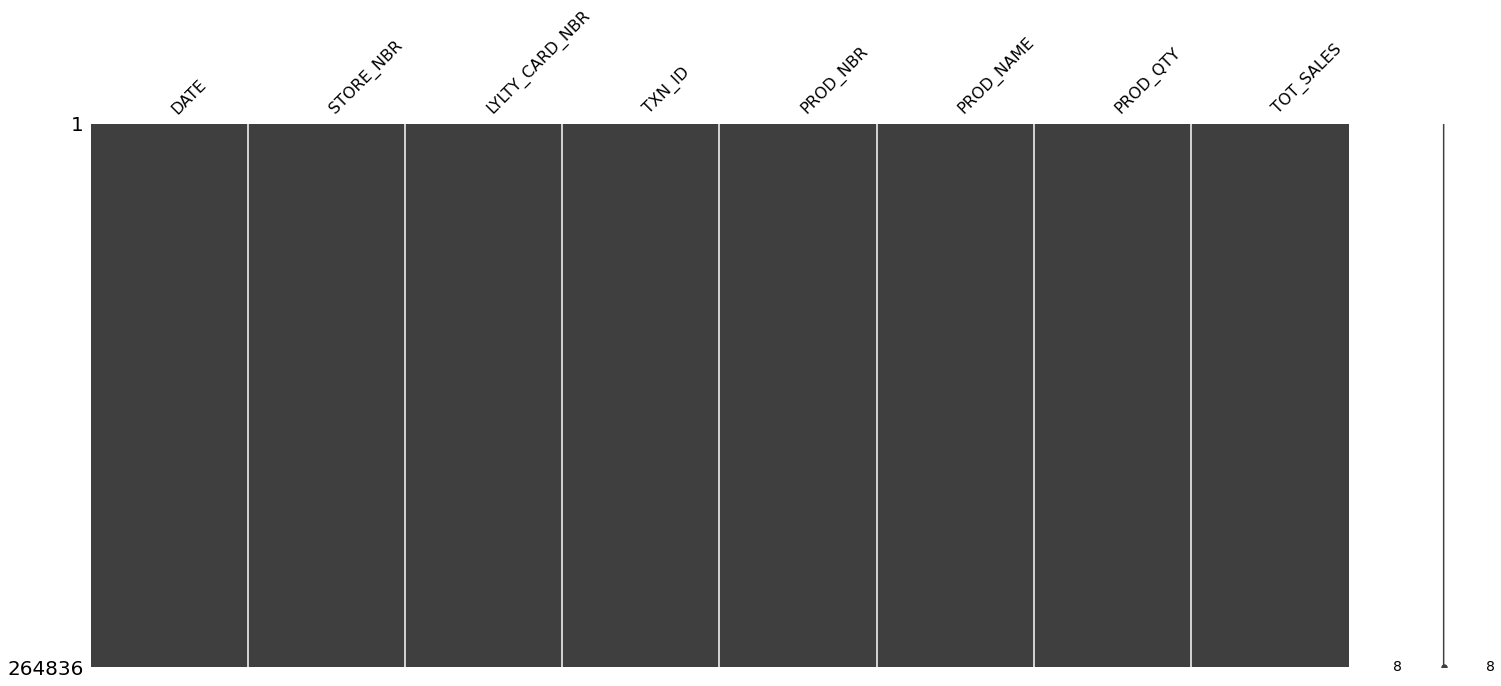

In [11]:
# For finding out whether there are any empty fields we need to prune out
missingno.matrix(transactionData_df)

This shows that there aren't any nulls within the entire dataset. If there were any, they would be indicated by white values within the respective subplots from where data would be missing 

##Individual Subplot Analyses
#*Dates Column*

In [12]:
list(transactionData_df.columns)

['DATE',
 'STORE_NBR',
 'LYLTY_CARD_NBR',
 'TXN_ID',
 'PROD_NBR',
 'PROD_NAME',
 'PROD_QTY',
 'TOT_SALES']

In [13]:
transactionData_df['DATE'].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

The source file for the transactional data we begun with was originally an excel file before we read it into a pandas dataframe, and it makes sense, therefore, that these values were formatted into Excel's default integer-date format. 

We can thus define a function to correct this as shown below:

In [14]:
# For formatting Excel integer-dates into yyyy-mm-dd format
def xlsdates_to_datetime(xlserialdate):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(xlserialdate < 60):
        delta_in_days = datetime.timedelta(days = (xlserialdate - 1))
    else:
        delta_in_days = datetime.timedelta(days = (xlserialdate - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date

In [16]:
#We then apply the defined function to the date column of our dataframe
transactionData_df['DATE'] = transactionData_df['DATE'].apply(xlsdates_to_datetime)

In [19]:
#And can confirm that the changes have been enacted
transactionData_df['DATE'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [22]:
#The dates in the dataframe should now be in the correct YYYY-MM-DD format
transactionData_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


#*Product Name Column*

In [27]:
#Let's explore
transactionData_df['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

The weights of the chips are vital data that we'll analyse, so we'll separate them from the chips' brand names

In [31]:
#Separation via the following functions
transactionData_df['PACK_SIZE'] = transactionData_df['PROD_NAME'].str.extract("(\d+)")
transactionData_df['PACK_SIZE'] = pd.to_numeric(transactionData_df['PACK_SIZE'])
transactionData_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [33]:
#For cleaning the PROD_NAME 
def separator(text):
    text = re.sub('[&/]', ' ', text) # remove special characters '&' and '/'
    text = re.sub('\d\w*', ' ', text) # remove product weights
    return text

# Run cleaning function to PROD_NAME column
transactionData_df['PROD_NAME'] = transactionData_df['PROD_NAME'].apply(separator)

In [34]:
# For writing brand names into a single string and running 'word_tokenize' to separate them
cleanProdName = transactionData_df['PROD_NAME']
string = ''.join(cleanProdName)
prodWord = word_tokenize(string)

In [35]:
# Run the 'fdist' function to calculate frequency of each token and put it into a dataframe
wordFrequency = fdist(prodWord)
freq_df = pd.DataFrame(list(wordFrequency.items()), columns = ["Word", "Frequency"]).sort_values(by = 'Frequency', ascending = False)

In [37]:
#We can therefore find out the brand with the most purchases
freq_df.head()

,Word,Frequency
10,Chips,49770
16,Kettle,40739
7,Smiths,28572
6,Cheese,27890
66,Pringles,24743


In [41]:
#It turns out that the purchases in the dataframe include transactions for salsa
#So we're gonna remove them since our analyses concerns just the chips
transactionData_df['PROD_NAME'] = transactionData_df['PROD_NAME'].apply(lambda x: x.lower())
transactionData_df = transactionData_df[~transactionData_df['PROD_NAME'].str.contains("salsa")]
transactionData_df['PROD_NAME'] = transactionData_df['PROD_NAME'].apply(lambda x: x.title())
transactionData_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150


#*Product Quantity Column*

In [43]:
# Value counts of PROD_QTY

transactionData_df['PROD_QTY'].value_counts()

2      220070
1       25476
5         415
3         408
4         371
200         2
Name: PROD_QTY, dtype: int64

Hmmmm 200 seems to be an outlier here. Let's probe that field

In [44]:
transactionData_df.loc[transactionData_df['PROD_QTY'] == 200, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


This transactions were all made by the same person, judging from the loyalty card number. It would be wise to look up more of their transactions using this same loyalty card number to see if there's any identifiable pattern.

In [46]:
transactionData_df.loc[transactionData_df['LYLTY_CARD_NBR'] == 226000, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


The first 2 transactions that were observed are the only ones this customer has made. From how they're buying a lot of chips but not too often, they seem to be wholesale buyers whose consumer patterns are evidently different from the class of consumers we're analysing now, so it makes sense to take them out of the analysis entirely.

In [49]:
transactionData_df.drop(transactionData_df.index[transactionData_df['LYLTY_CARD_NBR'] == 226000], inplace = True)
consumerData_df.drop(consumerData_df.index[consumerData_df['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [53]:
#And confirm from the rest of the dataframe that the fields have indeed been dropped
transactionData_df.loc[transactionData_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE


In [57]:
# We can then look through the number of transactions over time to see if there are any obvious data issues e.g. missing data
transactionData_df['DATE'].nunique()

364

In [59]:
#Let's see what day it is that there were no transactions on. Probably a public holiday
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(transactionData_df['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

In [61]:
#Christmas. Okay. 
#We can then compute and record the total sales for each date
a = pd.pivot_table(transactionData_df, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
a.head()

,TOT_SALES
DATE,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [63]:
b = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
b['TOT_SALES'] = 0
len(b)

365

In [64]:
c = a + b
c.fillna(0, inplace = True)

In [65]:
c.head()

,TOT_SALES
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [66]:
c.index.name = 'Date'
c.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
c.head() 

,Total Sales
Date,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


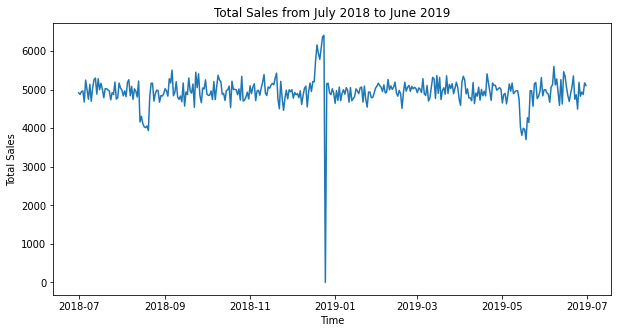

In [67]:
timeline = c.index
graph = c['Total Sales']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Total Sales')

plt.show()

That irregularly sharp spike corresponds to a possible holiday week sale

In [69]:
# Check the sales data to see whether it's Christmas when the count equals to zero

c[c['Total Sales'] == 0]

,Total Sales
Date,
2018-12-25,0.0


In [71]:
#Yep. We can zoom out to observe the entire month so that we can see the sharp declines and rises more easily
c_december = c[(c.index < "2019-01-01") & (c.index > "2018-11-30")]
c_december.head()

,Total Sales
Date,
2018-12-01,5000.9
2018-12-02,4781.1
2018-12-03,4927.0
2018-12-04,4869.4
2018-12-05,4900.5


Text(0.5, 1.0, 'Total December Sales')

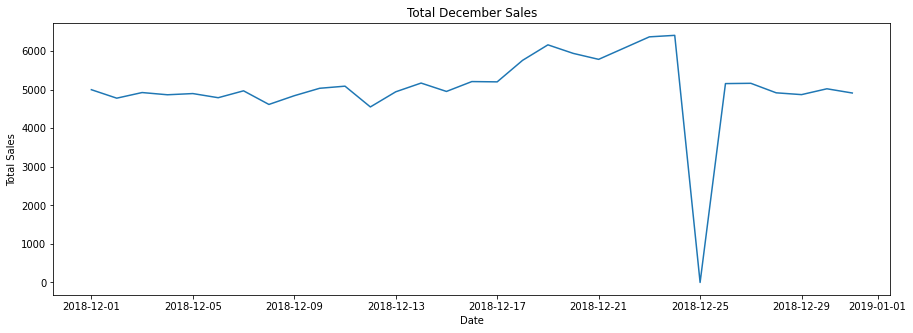

In [73]:
#as a chart
plt.figure(figsize = (15, 5))
plt.plot(c_december)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total December Sales')

In [75]:
# For resetting the index

c_december.reset_index(drop = True, inplace = True)
c_december.head()

,Total Sales
0,5000.9
1,4781.1
2,4927.0
3,4869.4
4,4900.5


In [76]:
# And relabelling the Date

c_december['Date'] = c_december.index + 1
c_december.head()

,Total Sales,Date
0,5000.9,1
1,4781.1,2
2,4927.0,3
3,4869.4,4
4,4900.5,5


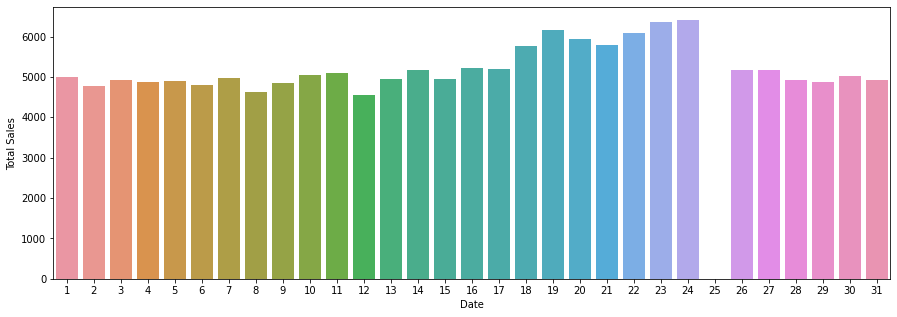

In [80]:
#For that good seaborn glaze and a focus on christmas closure
plt.figure(figsize = (15,5))
sns.barplot(x = 'Date', y ='Total Sales', data = c_december)

#*Pack Size Column*

In [82]:
transactionData_df['PACK_SIZE'].head()

0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [83]:
transactionData_df['PACK_SIZE'].unique()

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70])

Text(0.5, 1.0, 'Pack Size Histogram')

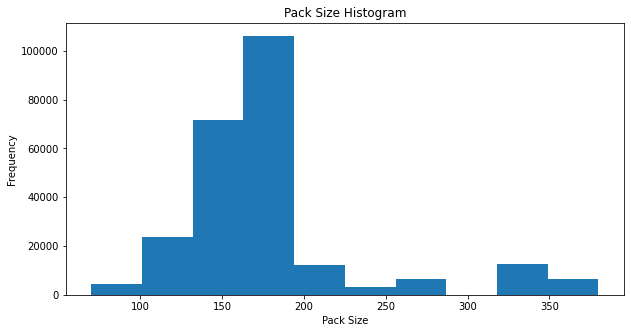

In [85]:
# For checking the distribution of PACK_SIZE

plt.figure(figsize = (10, 5))
plt.hist(transactionData_df['PACK_SIZE'])     
plt.xlabel('Pack Size')
plt.ylabel('Frequency')
plt.title('Pack Size Histogram')

In [87]:
# For extracting the brand name from PROD_NAME and create new column called BRAND

part = transactionData_df['PROD_NAME'].str.partition()
transactionData_df['BRAND'] = part[0]
transactionData_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,Ccs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle


In [89]:
transactionData_df['BRAND'].unique()

array(['Natural', 'Ccs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'Ww', 'Thins', 'Burger', 'Ncc', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'Grnwves',
       'Tyrrells', 'Cobs', 'French', 'Rrd', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [91]:
#We can standardize the brand names for consistency
# Rename brand names for consistency

transactionData_df['BRAND'].replace('Ncc', 'Natural', inplace = True)
transactionData_df['BRAND'].replace('Ccs', 'CCS', inplace = True)
transactionData_df['BRAND'].replace('Smith', 'Smiths', inplace = True)
transactionData_df['BRAND'].replace(['Grain', 'Grnwves'], 'Grainwaves', inplace = True)
transactionData_df['BRAND'].replace('Dorito', 'Doritos', inplace = True)
transactionData_df['BRAND'].replace('Ww', 'Woolworths', inplace = True)
transactionData_df['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
transactionData_df['BRAND'].replace(['Red', 'Rrd'], 'Red Rock Deli', inplace = True)
transactionData_df['BRAND'].replace('Snbts', 'Sunbites', inplace = True)

transactionData_df['BRAND'].unique()

array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Grainwaves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [93]:
# Investigating which brand had the most sales
transactionData_df.groupby('BRAND').TOT_SALES.sum().sort_values(ascending = False)

BRAND
Kettle           390239.8
Doritos          226329.9
Smiths           217492.0
Pringles         177655.5
Infuzions         99047.6
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Tyrrells          51647.4
Grainwaves        51617.2
Natural           42318.0
Woolworths        41059.1
Cheezels          40029.9
CCS               18078.9
Cheetos           16884.5
Sunbites           9676.4
French             7929.0
Burger             6831.0
Name: TOT_SALES, dtype: float64

# Analyzing The Consumer Data

In [96]:
list(consumerData_df.columns)

['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER']

In [98]:
consumerData_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


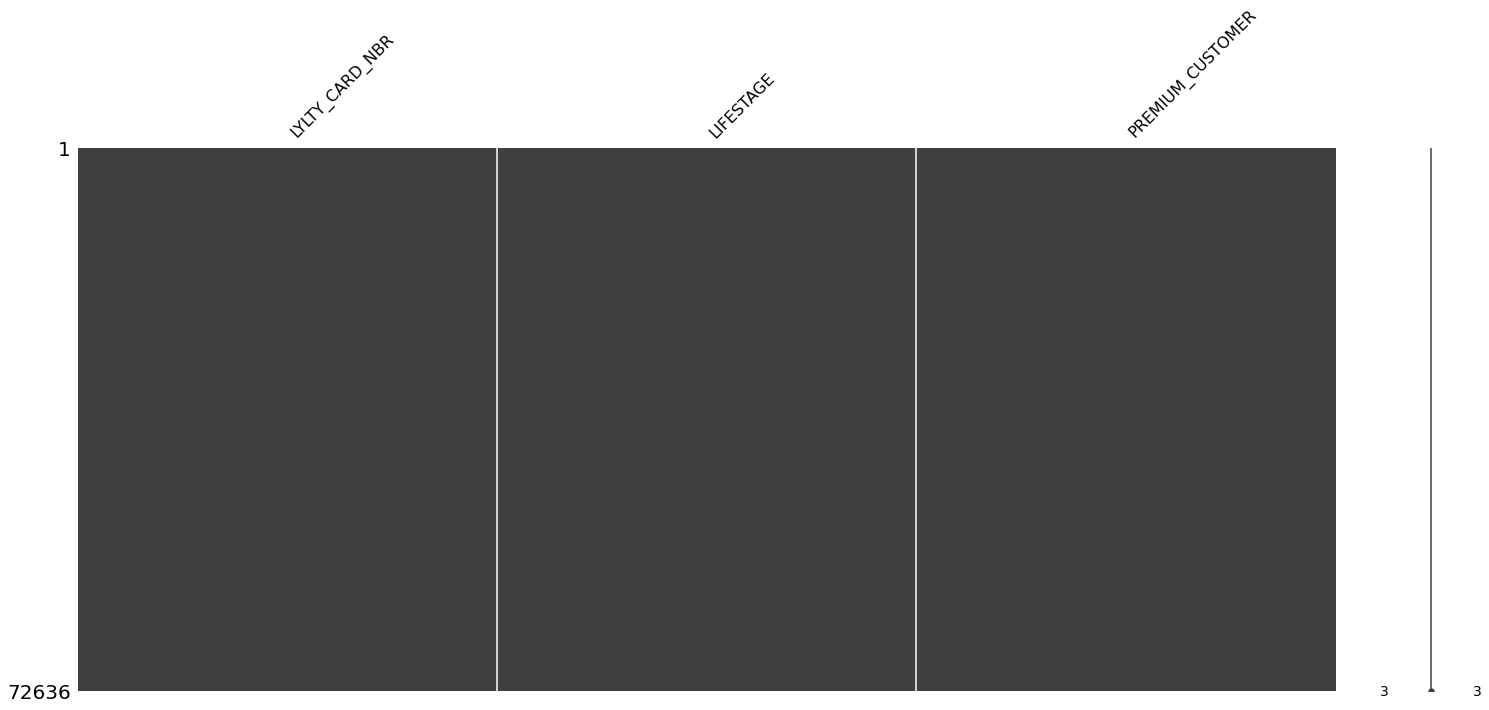

In [99]:
# For finding Missing values in customerData
missingno.matrix(consumerData_df)

In [100]:
len(consumerData_df)

72636

In [102]:
consumerData_df['LYLTY_CARD_NBR'].nunique()

72636

In [103]:
# For investigating the lifestages subplot

consumerData_df['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [105]:
#And counting them
consumerData_df['LIFESTAGE'].value_counts().sort_values(ascending = False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

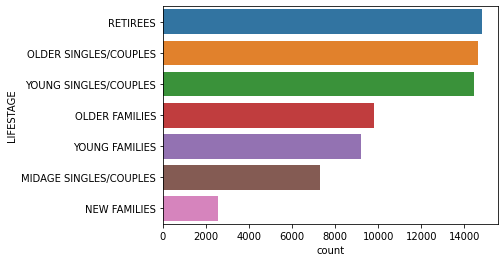

In [107]:
#Then plotting them
sns.countplot(y = consumerData_df['LIFESTAGE'], order = consumerData_df['LIFESTAGE'].value_counts().index)

In [108]:
# Investigating How many unique premium customer categories?
consumerData_df['PREMIUM_CUSTOMER'].nunique()

3

In [110]:
# Finding Value counts for each premium customer category
consumerData_df['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending = False)

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

Text(0, 0.5, 'Premium Customer')

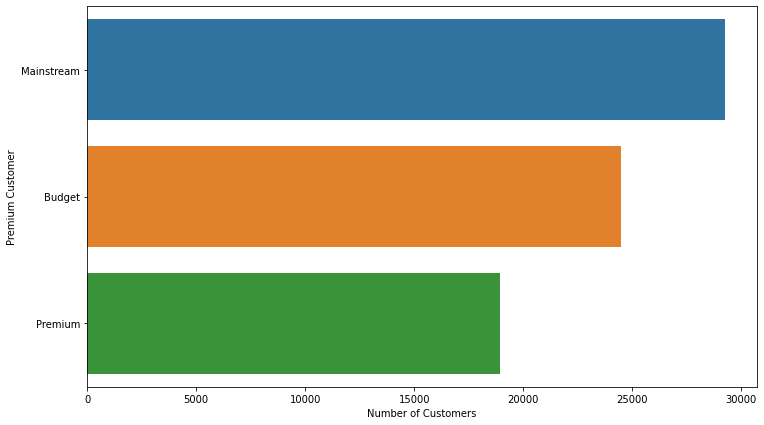

In [111]:
plt.figure(figsize = (12, 7))
sns.countplot(y = consumerData_df['PREMIUM_CUSTOMER'], order = consumerData_df['PREMIUM_CUSTOMER'].value_counts().index)
plt.xlabel('Number of Customers')
plt.ylabel('Premium Customer')

In [116]:
# For Merging transactionData and customerData together
combinedData = pd.merge(transactionData_df, consumerData_df)

In [118]:
print("Transaction data shape: ", transactionData_df.shape)
print("Customer data shape: ", consumerData_df.shape)
print("Combined data shape: ", combinedData.shape)

Transaction data shape:  (246740, 10)
Customer data shape:  (72636, 3)
Combined data shape:  (246740, 12)


In [121]:
# For checking for null values
combinedData.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

#Consumer Behaviour Analyses 
We can thus proceed to investigate some data points that are useful to the client by answering the  following questions:

* Who spends the most on chips, describing customers by lifestage and how premium their general purchasing behaviour is
* How many customers are in each segment
* How many chips are bought per customer by segment
* What is the average chip price by customer segment

In [122]:
# Investigating the Total sales by PREMIUM_CUSTOMER and LIFESTAGE
sales = pd.DataFrame(combinedData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales

Total Sales
PREMIUM_CUSTOMER LIFESTAGE                          
Budget           OLDER FAMILIES            156863.75
Mainstream       YOUNG SINGLES/COUPLES     147582.20
                 RETIREES                  145168.95
Budget           YOUNG FAMILIES            129717.95
                 OLDER SINGLES/COUPLES     127833.60
Mainstream       OLDER SINGLES/COUPLES     124648.50
Premium          OLDER SINGLES/COUPLES     123537.55
Budget           RETIREES                  105916.30
Mainstream       OLDER FAMILIES             96413.55
Premium          RETIREES                   91296.65
Mainstream       YOUNG FAMILIES             86338.25
                 MIDAGE SINGLES/COUPLES     84734.25
Premium          YOUNG FAMILIES             78571.70
                 OLDER FAMILIES             75242.60
Budget           YOUNG SINGLES/COUPLES      57122.10
Premium          MIDAGE SINGLES/COUPLES     54443.85
                 YOUNG SINGLES/COUPLES      39052.30
Budget           MIDAGE SINGLES/COUPLES     33345.70
                 NEW FAMILIES               20607.45
Mainstream       NEW FAMILIES               15979.70
Premium          NEW FAMILIES               10760.80

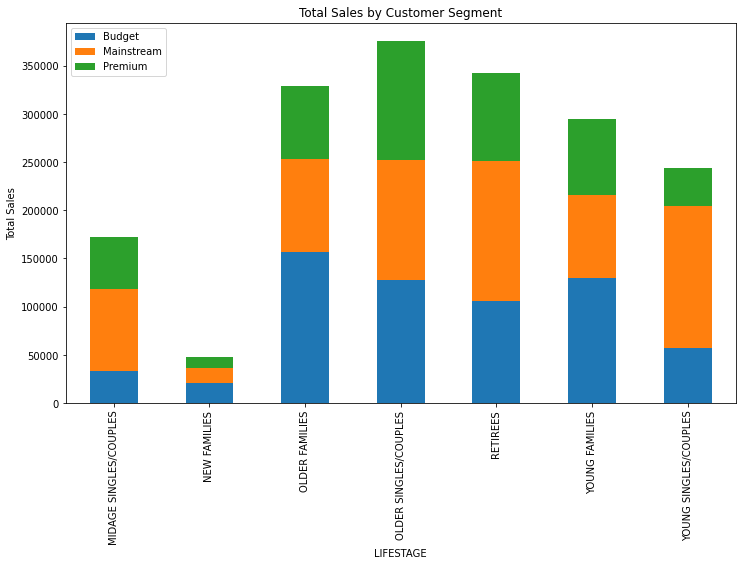

In [123]:
# Visualising the results
salesPlot = pd.DataFrame(combinedData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())
salesPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

It is observed that the top three consumer groups are  budget older families, mainstream young singles/couples and mainstream retirees.

In [124]:
# Investigating the number of consumers by PREMIUM_CUSTOMER and LIFESTAGE

consumers = pd.DataFrame(combinedData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
consumers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
consumers.sort_values(by = 'Number of Customers', ascending = False).head(10)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                 
Mainstream       YOUNG SINGLES/COUPLES                 7917
                 RETIREES                              6358
                 OLDER SINGLES/COUPLES                 4858
Budget           OLDER SINGLES/COUPLES                 4849
Premium          OLDER SINGLES/COUPLES                 4682
Budget           OLDER FAMILIES                        4611
                 RETIREES                              4385
                 YOUNG FAMILIES                        3953
Premium          RETIREES                              3812
Budget           YOUNG SINGLES/COUPLES                 3647

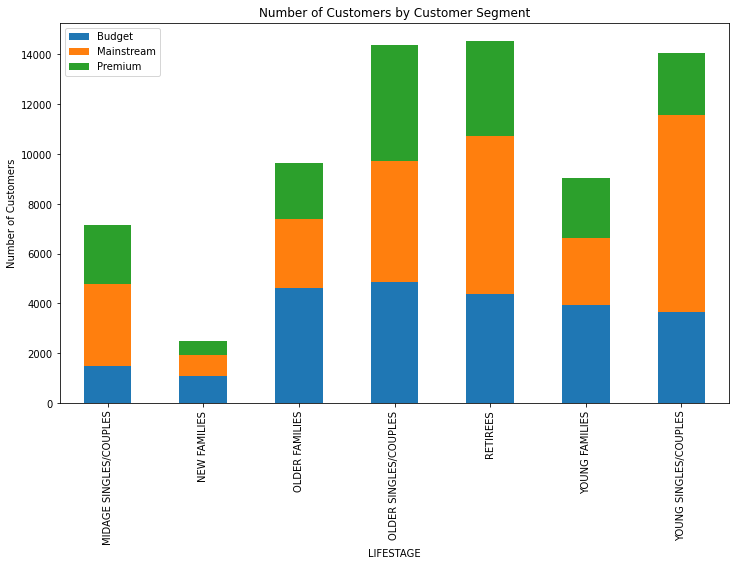

In [125]:
# Visualising the results

consumersPlot = pd.DataFrame(combinedData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
consumersPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Number of Customers by Customer Segment')
plt.ylabel('Number of Customers')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

The fact that there are more mainstream young singles/couples and retirees contributes to to more chips sales in these segments however this is not the major driver for the budget older families segment.

In [126]:
# Investigating the Average units per customer by PREMIUM_CUSTOMER and LIFESTAGE

avg_units = combinedData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / combinedData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units, columns = {'Average Unit per Customer'})
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.255380
Budget,OLDER FAMILIES,9.076773
Premium,OLDER FAMILIES,9.071717
Budget,YOUNG FAMILIES,8.722995
Premium,YOUNG FAMILIES,8.716013


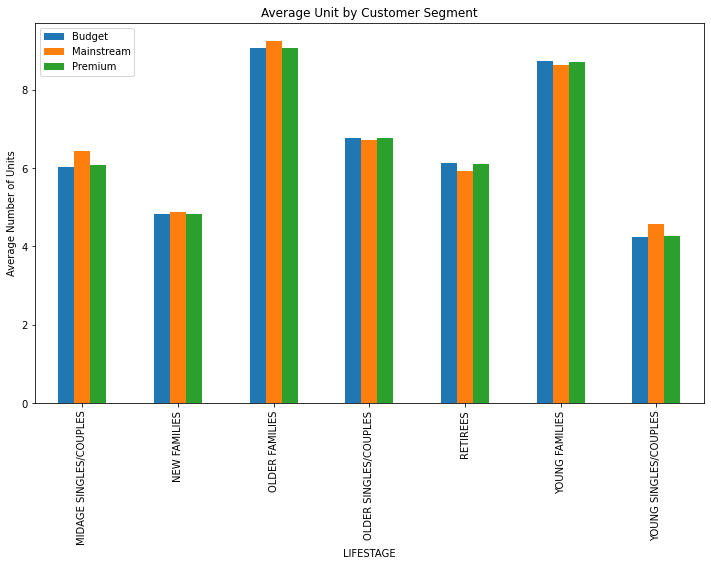

In [128]:
# Visualising the results

avgUnitsPlot = pd.DataFrame(combinedData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / combinedData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
avgUnitsPlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Unit by Customer Segment')
plt.ylabel('Average Number of Units')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

From the chart above, it is observed that older families and young families buy more chips per customer.

In [129]:
# Investigating the average price per unit by PREMIUM_CUSTOMER and LIFESTAGE

avg_price = combinedData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / combinedData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()

Price per Unit
PREMIUM_CUSTOMER LIFESTAGE                             
Mainstream       YOUNG SINGLES/COUPLES         4.074043
                 MIDAGE SINGLES/COUPLES        3.994449
                 NEW FAMILIES                  3.935887
Budget           RETIREES                      3.932731
                 NEW FAMILIES                  3.931969

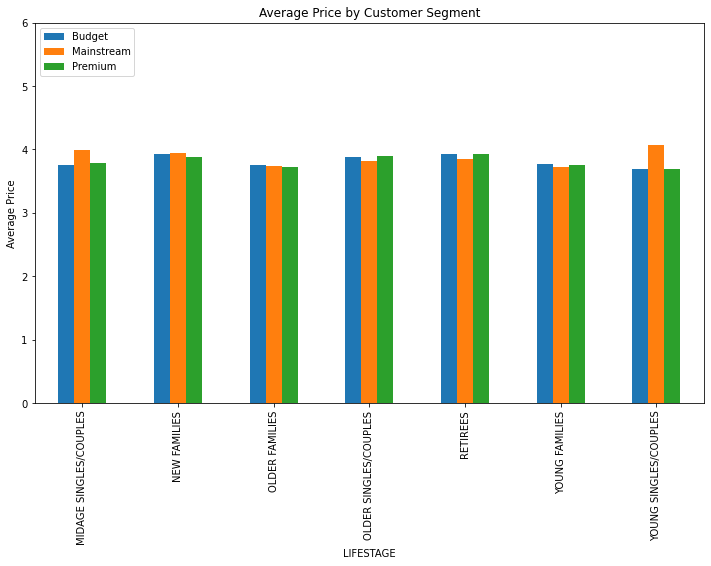

In [131]:
# Visualising the results

avgPricePlot = pd.DataFrame(combinedData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum() / combinedData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
avgPricePlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Price by Customer Segment', ylim = (0, 6))
plt.ylabel('Average Price')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

Mainstream midage as well as young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to their membership within the premium customers' group. Hence, they are more likely to buy healthy snacks and when they do buy chips, it is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

In [133]:
# We can use an independent t-test between mainstream vs non-mainstream midage and young singles/couples to (dis)prove this difference

# Create a new dataframe pricePerUnit
pricePerUnit = combinedData

# Create a new column under pricePerUnit called PRICE
pricePerUnit['PRICE'] = pricePerUnit['TOT_SALES'] / pricePerUnit['PROD_QTY']

# Let's have a look
pricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2018-11-10,1,1307,346,96,Ww Original Stacked Chips,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget,1.90
3,2019-03-09,1,1307,347,54,Ccs Original,1,2.1,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45


In [135]:
# Proceed to group our data into mainstream and non-mainstream

mainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
nonMainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')), 'PRICE']

Text(0.5, 0, 'Price per Unit')

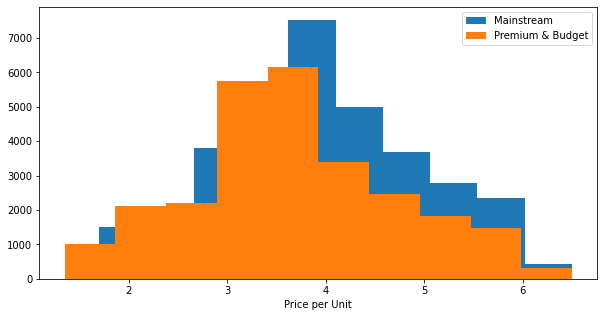

In [137]:
# Then compare their histograms across mainstream and non-mainstream customers
plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(nonMainstream, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')

In [138]:
print("Mainstream average price per unit: ${:.2f}".format(np.mean(mainstream)))
print("Non-mainstream average price per unit: ${:.2f}".format(np.mean(nonMainstream)))
if np.mean(mainstream) > np.mean(nonMainstream):
    print("Mainstream customers have higher average price per unit. ")
else:
    print("Non-mainstream customers have a higher average price per unit. ")

Mainstream average price per unit: $4.04
Non-mainstream average price per unit: $3.71
Mainstream customers have higher average price per unit. 


In [139]:
# Proceed to perform the t-test 

ttest_ind(mainstream, nonMainstream)

Ttest_indResult(statistic=37.83196107667825, pvalue=2.235645611540966e-309)

Consumers within the 'Mainstream Customers' group have been confirmed have higher average price per unit than that of non-mainstream customers.

Deeper levels of understanding the consumers can be obtained by further analysis from this point, beginning by examining mainstream young singles/couples against the rest of the cutomer segments to see if they prefer any particular brand of chips.

In [143]:
target = combinedData.loc[(combinedData['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (combinedData['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
nonTarget = combinedData.loc[(combinedData['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (combinedData['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
target.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag Sauce,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-10-02,1,1020,27,7,Smiths Crinkle Original,1,5.7,330,Smiths,YOUNG SINGLES/COUPLES,Mainstream,5.7
221347,2019-05-02,1,1020,28,84,Grnwves Plus Btroot Chilli Jam,1,3.1,180,Grainwaves,YOUNG SINGLES/COUPLES,Mainstream,3.1
221348,2018-08-17,1,1163,188,46,Kettle Original,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
221349,2019-02-07,1,1163,189,12,Natural Chip Co Tmato Hrb Spce,1,3.0,175,Natural,YOUNG SINGLES/COUPLES,Mainstream,3.0


#*Consumer Brand Affinity Analysis*

In [144]:
# Target Segment
targetBrand = target.loc[:, ['BRAND', 'PROD_QTY']]
targetSum = targetBrand['PROD_QTY'].sum()
targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / targetSum
targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())

# Non-target segment
nonTargetBrand = nonTarget.loc[:, ['BRAND', 'PROD_QTY']]
nonTargetSum = nonTargetBrand['PROD_QTY'].sum()
nonTargetBrand['Non-Target Brand Affinity'] = nonTargetBrand['PROD_QTY'] / nonTargetSum
nonTargetBrand = pd.DataFrame(nonTargetBrand.groupby('BRAND')['Non-Target Brand Affinity'].sum())

In [146]:
# The proceed to merge the two dataframes together
brand_proportions = pd.merge(targetBrand, nonTargetBrand, left_index = True, right_index = True)
brand_proportions.head()

,Target Brand Affinity,Non-Target Brand Affinity
BRAND,,
Burger,0.002926,0.006538
CCS,0.011180,0.018445
Cheetos,0.008033,0.011759
Cheezels,0.017971,0.018904
Cobs,0.044638,0.038449


In [147]:
brand_proportions['Affinity to Brand'] = brand_proportions['Target Brand Affinity'] / brand_proportions['Non-Target Brand Affinity']
brand_proportions.sort_values(by = 'Affinity to Brand', ascending = False)

,Target Brand Affinity,Non-Target Brand Affinity,Affinity to Brand
BRAND,,,
Tyrrells,0.031553,0.025715,1.227025
Twisties,0.046184,0.037933,1.217506
Doritos,0.122761,0.101171,1.213397
Kettle,0.197985,0.166560,1.188667
Tostitos,0.045411,0.038350,1.184100
Pringles,0.119420,0.101110,1.181090
Cobs,0.044638,0.038449,1.160959
Infuzions,0.064679,0.057410,1.126622
Thins,0.060373,0.057159,1.056217


It is observed that Mainstream young singles/couples are more likely to purchase Tyrrells chips compared to other brands.

#*Consumer Pack Size Affinity Analysis*

In [148]:
# Target segment 
targetSize = target.loc[:, ['PACK_SIZE', 'PROD_QTY']]
targetSum = targetSize['PROD_QTY'].sum()
targetSize['Target Pack Affinity'] = targetSize['PROD_QTY'] / targetSum
targetSize = pd.DataFrame(targetSize.groupby('PACK_SIZE')['Target Pack Affinity'].sum())

# Non-target segment
nonTargetSize = nonTarget.loc[:, ['PACK_SIZE', 'PROD_QTY']]
nonTargetSum = nonTargetSize['PROD_QTY'].sum()
nonTargetSize['Non-Target Pack Affinity'] = nonTargetSize['PROD_QTY'] / nonTargetSum
nonTargetSize = pd.DataFrame(nonTargetSize.groupby('PACK_SIZE')['Non-Target Pack Affinity'].sum())

In [150]:
# Proceed to merge the two dataframes together
pack_proportions = pd.merge(targetSize, nonTargetSize, left_index = True, right_index = True)
pack_proportions.head()

,Target Pack Affinity,Non-Target Pack Affinity
PACK_SIZE,,
70,0.003037,0.006284
90,0.006349,0.012613
110,0.106280,0.089575
125,0.003009,0.005976
134,0.119420,0.101110


In [151]:
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity'] / pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by = 'Affinity to Pack', ascending = False)

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
PACK_SIZE,,,
270,0.031829,0.025070,1.269608
380,0.032160,0.025711,1.250827
330,0.061284,0.050974,1.202243
110,0.106280,0.089575,1.186492
134,0.119420,0.101110,1.181090
210,0.029124,0.024891,1.170020
135,0.014769,0.012931,1.142086
250,0.014355,0.012863,1.115959
170,0.080773,0.080347,1.005300


Furthermore, it has been observed that mainstream singles/couples are more likely to purchase a 270g pack size compared to other pack sizes. The brand(s) that offer chips in this size can be confirmed below

In [154]:
# Fining out which brand offers 270g pack size?
combinedData.loc[combinedData['PACK_SIZE'] == 270, :].head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
34,2019-05-18,9,9208,8634,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
79,2018-08-24,39,39167,35639,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
125,2019-05-06,54,54305,48304,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
132,2019-05-20,55,55073,48887,113,Twisties Chicken,1,4.6,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
209,2019-01-01,80,80182,78980,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
252,2018-11-18,84,84096,83672,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
253,2019-05-20,88,88320,87811,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
278,2018-07-11,102,102115,102207,15,Twisties Cheese,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
347,2019-04-05,118,118007,120735,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6
350,2018-07-01,119,119051,122360,113,Twisties Chicken,2,9.2,270,Twisties,MIDAGE SINGLES/COUPLES,Budget,4.6


In [155]:
# Then confirm whether Twisties is the only brand that sells the 270g pack size
combinedData.loc[combinedData['PACK_SIZE'] == 270, 'BRAND'].unique()

array(['Twisties'], dtype=object)

It is confirmed that Twisties is the only brand that offers 270g pack size.

#*Conclusions*
1. The consumer groups with the highest propoertions of sales are (Budget, OLDER FAMILIES), (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES) and as such; they are the most profitable consumer groups to target and optimize production for.
2. It has been observed and confirmed by the data that (Mainstream, YOUNG SINGLES/COUPLES) and (Mainstream, RETIREES) are bigger spenders than any other single consumer group examined in isolation due to the fact that there are more consumers in the afore menntioned groups.
3. From the consumer behaviour data on spending, it has been observed and confirmed by data that (Mainstream, YOUNG SINGLES/COUPLES) are more likely to pay more per packet of chips than their premium and budget counterparts.
Their preference as per the brand of chips is also highest for the chip brand 'Tyrrells', specifically in the '270g' pack conformation in comparison to the rest of the population.